### Examine the Data

In [32]:
# Importing librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import statsmodels.api as sm

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [33]:

# Read the dataset
df_raw = pd.read_csv('valueflip_training.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'MS'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [34]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

### Plot the source data

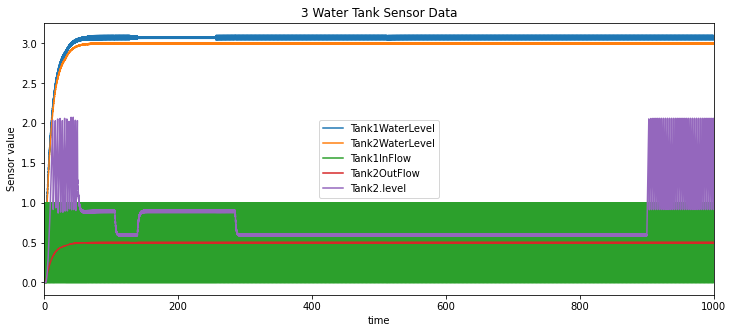

In [35]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)

df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [36]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [37]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.255233e+01
p-value                 2.192107e-23
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [38]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [39]:
# def normalise_timeseries(data):
#     # Calculate the mean and standard deviation for each feature
#     means = np.mean(data, axis=0)
#     stds = np.std(data, axis=0)
    
#     # Normalise each feature using standard deviation
#     normalised_data = (data - means) / stds
    
#     return pd.DataFrame(normalised_data), means, stds

In [40]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [41]:
df = normalised_data

In [42]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
0.10,-13.736104,-13.647793,0.998751,-11.718138,-2.764683,-1.531894,-1.265579
0.15,-13.504895,-13.607095,0.998751,-11.718138,-2.764683,-1.531894,-1.265579
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,0.361705,2.614455,1.082095
999.85,0.239056,0.140814,0.998751,0.133595,-2.764683,2.473365,1.002209
999.90,0.175745,0.174565,-1.001251,0.169767,-2.764683,-1.531894,1.065828


In [43]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### VAR Model Order Selection

In [44]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 43 has the least AIC value. Let us select p = 43 in the modelling


In [45]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [46]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [47]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [48]:
min_aic_index

43

In [49]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Jul, 2023
Time:                     18:06:10
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -76.0600
Nobs:                     16958.0    HQIC:                  -76.7065
Log likelihood:           486770.    FPE:                3.53684e-34
AIC:                     -77.0247    Det(Omega_mle):     3.12574e-34
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.011908         0.000427          -27.893           0.000
L1.Tank1WaterLevel          0.261374         0.009406           27.789           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [50]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

43

In [51]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
0.10,-13.736104,-13.647793,0.998751,-11.718138,-2.764683,-1.531894,-1.265579
0.15,-13.504895,-13.607095,0.998751,-11.718138,-2.764683,-1.531894,-1.265579
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579


In [52]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.16543401,  0.12356963,  0.99838694,  0.12650435,  0.36082796,
        -1.5298889 ,  0.22827329],
       [ 0.27070904,  0.15466211,  0.99712275,  0.14419649, -2.76496125,
         1.03042884,  0.18531212],
       [ 0.17571124,  0.17457594, -1.00224863,  0.16978376,  0.35900845,
        -1.53401162,  0.2281747 ],
       [ 0.05753152,  0.15648558, -1.00142295,  0.16828216, -2.76836843,
         1.02445875,  0.1857143 ],
       [ 0.06899911,  0.12955062,  0.99990234,  0.14378574,  0.35790854,
        -1.53918358,  0.22892102],
       [ 0.20447856,  0.13009381,  0.99996766,  0.1273128 , -2.76670061,
         1.02387362,  0.18635363],
       [ 0.27056333,  0.15472034,  0.98795284,  0.14424688,  0.35890578,
        -1.53608951,  0.229295  ],
       [ 0.13102893,  0.17371476, -1.00446913,  0.17537505, -2.76617804,
         1.02541241,  0.1866599 ],
       [ 0.05734523,  0.15637263, -0.99846574,  0.16820162,  0.35836831,
        -1.53517483,  0.2297562 ],
       [ 0.12118925,  0.1227

In [53]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
850.05,0.165423,0.123577,0.998751,0.126510,0.361705,-1.531894,0.228312
850.10,0.270704,0.154650,0.998751,0.144185,-2.764683,1.030743,0.185393
850.15,0.175745,0.174565,-1.001251,0.169767,0.361705,-1.531894,0.228130
850.20,0.057638,0.156503,-1.001251,0.168293,-2.764683,1.030882,0.185471
850.25,0.068970,0.129598,0.998751,0.143823,0.361705,-1.531894,0.228315
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,0.361705,2.614455,1.082095
999.85,0.239056,0.140814,0.998751,0.133595,-2.764683,2.473365,1.002209
999.90,0.175745,0.174565,-1.001251,0.169767,-2.764683,-1.531894,1.065828


In [54]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.165434,0.123570,0.998387,0.126504,0.360828,-1.529889,0.228273
1,0.270709,0.154662,0.997123,0.144196,-2.764961,1.030429,0.185312
2,0.175711,0.174576,-1.002249,0.169784,0.359008,-1.534012,0.228175
3,0.057532,0.156486,-1.001423,0.168282,-2.768368,1.024459,0.185714
4,0.068999,0.129551,0.999902,0.143786,0.357909,-1.539184,0.228921


### Plot the results

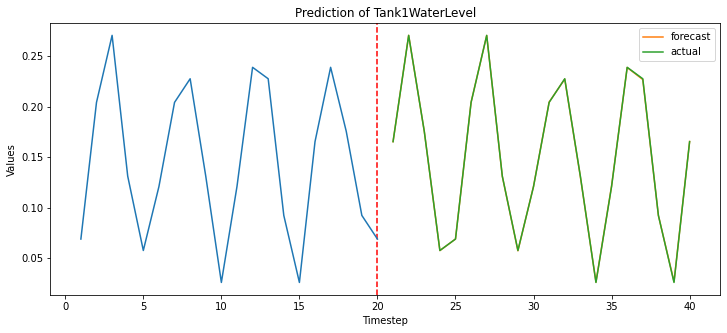

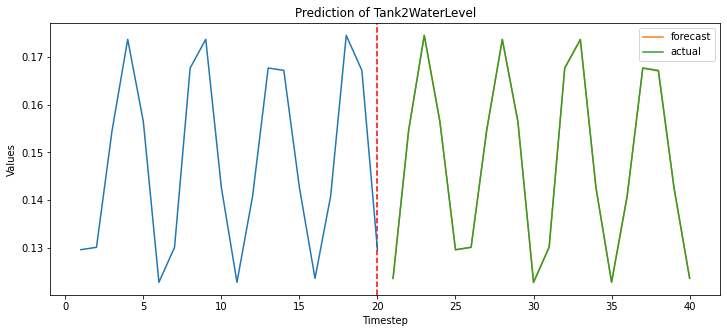

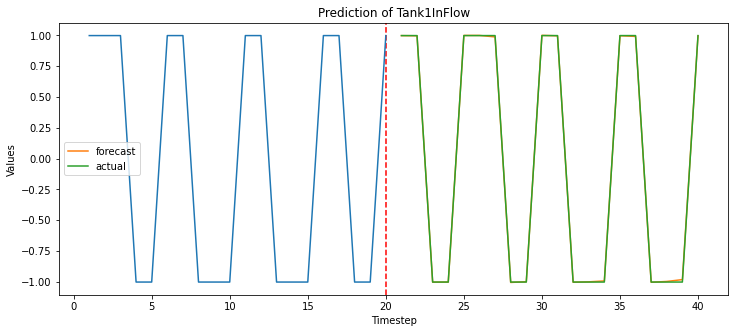

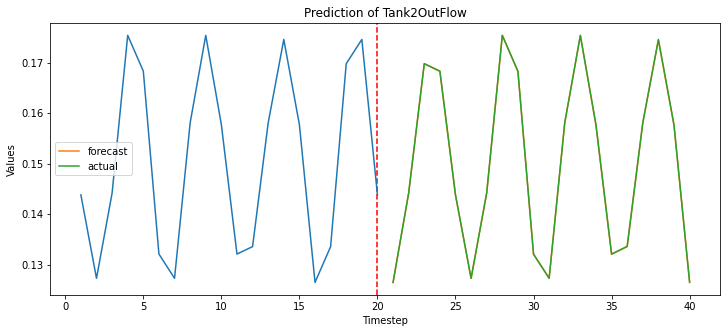

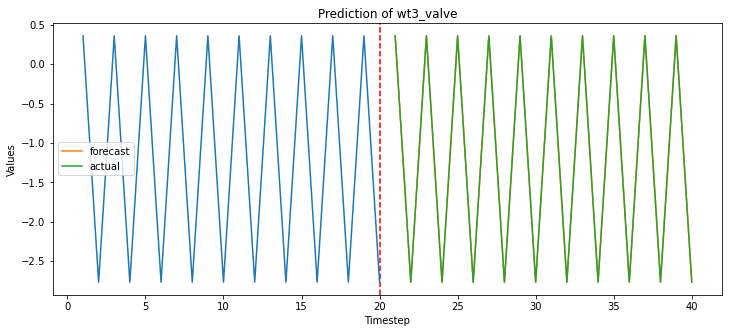

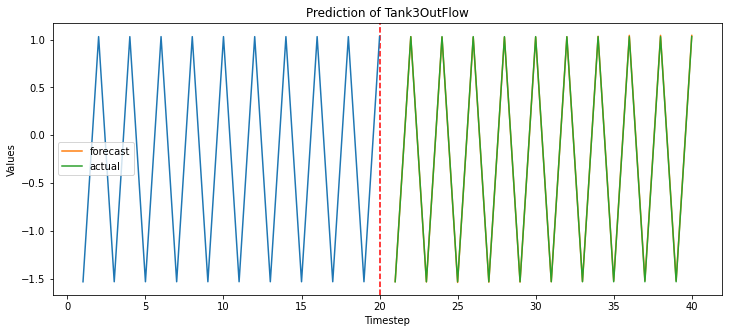

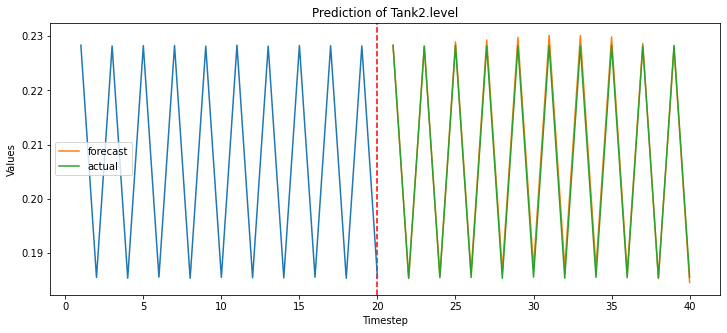

In [55]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# input_length = 20
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(1, input_length+1)))
#     actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    


attr = list(pd.read_csv('valueflip_training.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

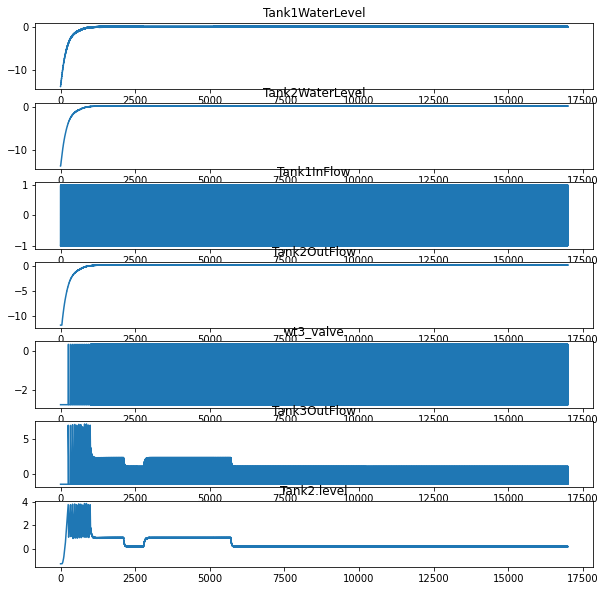

In [56]:
results.plot();

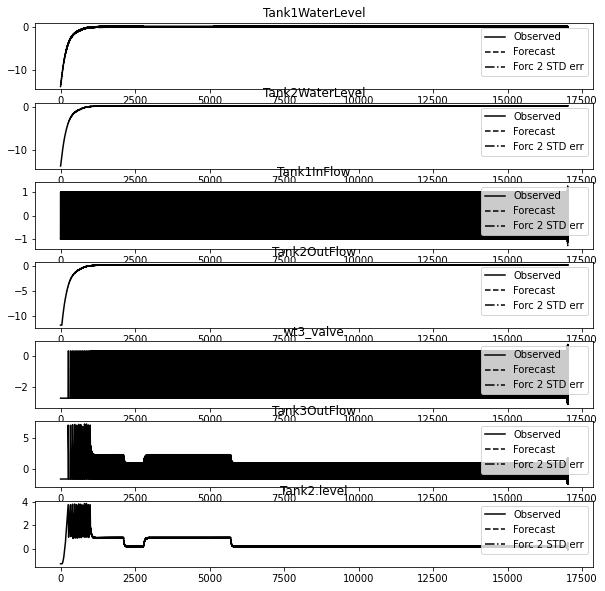

In [57]:
results.plot_forecast(20);

In [58]:
len(df_forecast)

20

In [59]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [60]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat].iloc[:steps], actual_test[feat]))

print(RMSE) 

[0.0003539628692371564, 7.670854666909514e-05, 0.005939489827399321, 7.308548023632161e-05, 0.003657779680534694, 0.00790957675031768, 0.0011844805410893896]


### Save the model

In [61]:
# Serialize andsave the model

with open('var_ctrl_valueFlip_perm.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


In [62]:
print(error)

NameError: name 'error' is not defined

### Define the faulty data

In [ ]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)

faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

### Load the model and reconstruct VAR

In [ ]:
with open('var_ctrl_valueFlip.pkl', 'rb') as f:
    params = pickle.load(f)
    
valueFlip_model = sm.tsa.VAR(train)
valueFlip_model.params = params
valueFlip_model_fit = valueFlip_model.fit(min_aic_index)

valueFlip_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = valueFlip_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of the faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = valueFlip_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

In [ ]:
import keyword
print(keyword.kwlist)

In [ ]:
print("Hello")